In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification/

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/versions/
License(s): ODbL-1.0
100% 733M/736M [00:33<00:00, 24.7MB/s]
100% 736M/736M [00:33<00:00, 23.0MB/s]


**# Data Preprocessing Dan Data Exploration**

In [6]:
import zipfile

with zipfile.ZipFile('eye-diseases-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('eye-diseases-classification')

Class: normal - Jumlah Sampel: 1074
-----------------------------------------------------


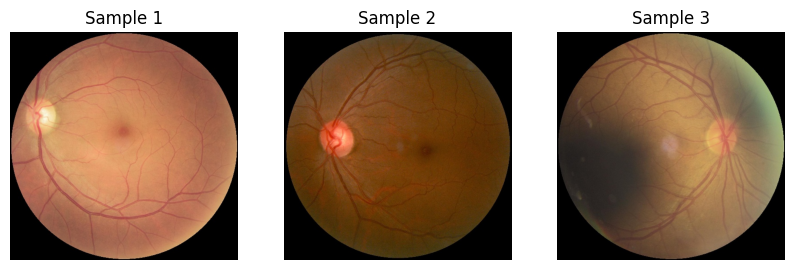



Class: cataract - Jumlah Sampel: 1038
-----------------------------------------------------


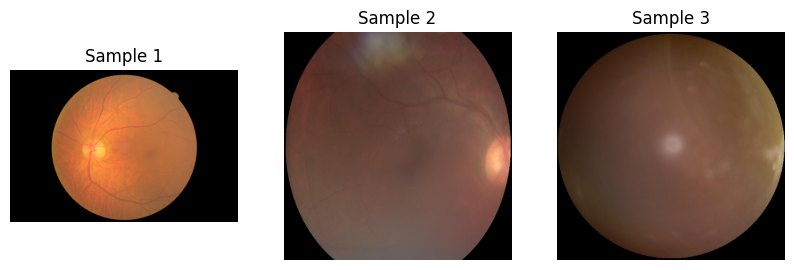



Class: diabetic_retinopathy - Jumlah Sampel: 1098
-----------------------------------------------------


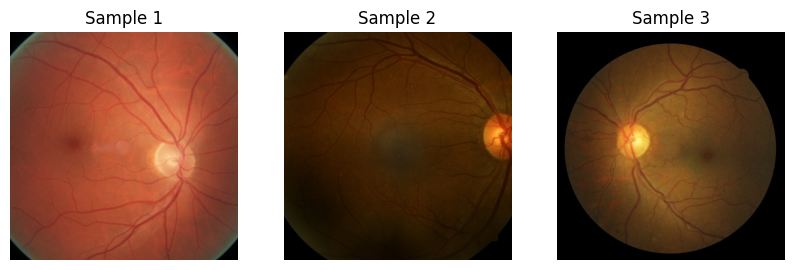



Class: glaucoma - Jumlah Sampel: 1007
-----------------------------------------------------


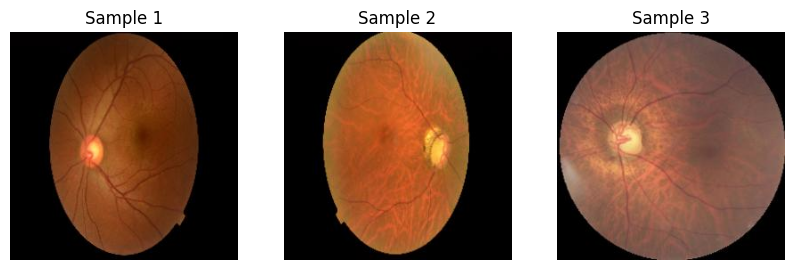

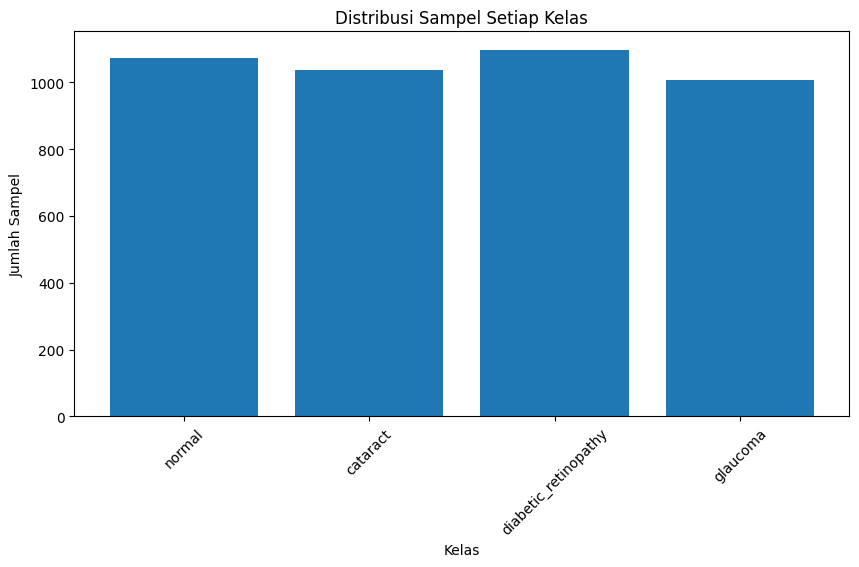

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Definisikan lokasi folder dataset
dataset_folder = "/content/eye-diseases-classification/dataset"

# Buat dictionary untuk menyimpan jumlah sampel setiap kelas
class_counts = {}

# Loop melalui setiap kelas
for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)

    # Pastikan yang di-loop adalah folder, bukan file
    if os.path.isdir(class_folder):
        # Hitung jumlah gambar dalam setiap kelas
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

        # Tampilkan beberapa contoh gambar dari setiap kelas
        print(f"Class: {class_name} - Jumlah Sampel: {num_images}")
        print("-----------------------------------------------------")
        plt.figure(figsize=(10, 5))
        for i, image_file in enumerate(os.listdir(class_folder)[:3]):
            # Path lengkap menuju gambar
            image_path = os.path.join(class_folder, image_file)
            # Membaca dan menampilkan gambar menggunakan Matplotlib
            plt.subplot(1, 3, i + 1)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f"Sample {i + 1}")
            plt.axis('off')  # Menghilangkan sumbu
        plt.show()
        print("\n")

# Tampilkan distribusi sampel setiap kelas
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribusi Sampel Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.show()


# **Split Model**

In [8]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Direktori dataset
dataset_dir = "/content/eye-diseases-classification/dataset/"

# List tiap Class
classes = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Ratio train, validation, dan test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop tiap class
for class_name in classes:
    # Path to the current class directory
    class_dir = os.path.join(dataset_dir, class_name)

    # List all files in the class directory
    files = os.listdir(class_dir)

    # Split files into train, val, test using sklearn train_test_split twice
    # First split: train (80%), remaining (20%)
    train_files, remaining_files = train_test_split(files, train_size=train_ratio, random_state=42)

    # Second split: val (10%), test (10%)
    val_files, test_files = train_test_split(remaining_files, train_size=0.5, random_state=42)

    # Membuat direktori baru train, validation, dan test sets
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)

        # Pindah file ke tempat yang sesuai dengan class
        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)


# **Data Augmentation Dan Normalization **

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Direktori dataset
dataset_dir = "/content/eye-diseases-classification/dataset/"

# Dimensi sebuah gambar
img_width, img_height = 256, 256

# ukuran Batch image
batch_size = 32

# Data augmentation dan normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
 )
val_datagen = ImageDataGenerator(rescale=1./255)  #  normalization for validation set
test_datagen = ImageDataGenerator(rescale=1./255)  # normalization for test set

# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 3372 images belonging to 4 classes.
Found 422 images belonging to 4 classes.
Found 423 images belonging to 4 classes.


Model CNN 5 Layer

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Mendefinisikan CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))  # Output layer dengan 4 kelas


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [17]:
# Compile the model dengan optimizer Adam dan learning rate yang diatur
optimizer = Adam(learning_rate=0.0001)  # Ganti 0.001 dengan nilai learning rate yang diinginkan
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size)

# evaluasi model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

Epoch 1/50
105/105 [==============================] - 29s 259ms/step - loss: 1.0410 - accuracy: 0.5452 - val_loss: 0.8415 - val_accuracy: 0.6298
Epoch 2/50
105/105 [==============================] - 28s 269ms/step - loss: 0.7706 - accuracy: 0.6832 - val_loss: 0.7078 - val_accuracy: 0.7091
Epoch 3/50
105/105 [==============================] - 28s 264ms/step - loss: 0.6815 - accuracy: 0.7228 - val_loss: 0.6751 - val_accuracy: 0.6971
Epoch 4/50
105/105 [==============================] - 28s 264ms/step - loss: 0.5789 - accuracy: 0.7772 - val_loss: 0.5434 - val_accuracy: 0.7981
Epoch 5/50
105/105 [==============================] - 26s 252ms/step - loss: 0.5559 - accuracy: 0.7781 - val_loss: 0.5406 - val_accuracy: 0.7764
Epoch 6/50
105/105 [==============================] - 26s 248ms/step - loss: 0.5093 - accuracy: 0.7937 - val_loss: 0.4699 - val_accuracy: 0.8197
Epoch 7/50
105/105 [==============================] - 27s 257ms/step - loss: 0.4749 - accuracy: 0.8102 - val_loss: 0.4435 - val_ac

# **Visualisasi Evaluasi Accuracy Model**

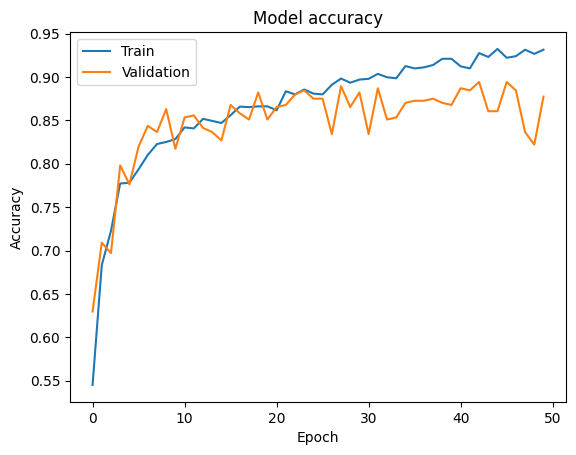

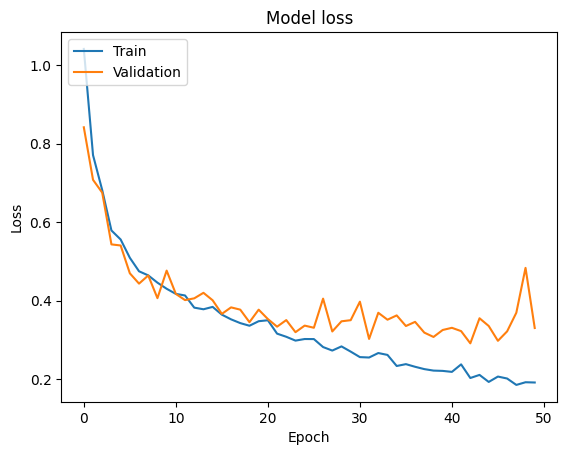

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Evaluasi Mode Confusion Matrix, Precission, recall, dan F1-Score**

14/14 [==============================] - 3s 234ms/step


<Figure size 800x800 with 0 Axes>

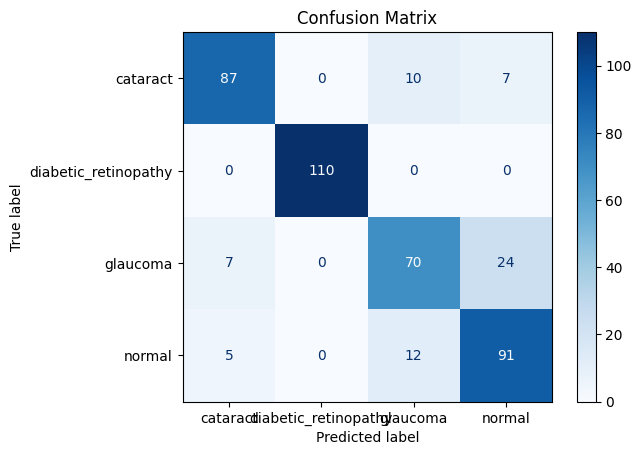

                      precision    recall  f1-score   support

            cataract       0.88      0.84      0.86       104
diabetic_retinopathy       1.00      1.00      1.00       110
            glaucoma       0.76      0.69      0.73       101
              normal       0.75      0.84      0.79       108

            accuracy                           0.85       423
           macro avg       0.85      0.84      0.84       423
        weighted avg       0.85      0.85      0.85       423



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil prediksi kelas dari model pada dataset uji
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Ambil label sebenarnya dari dataset uji
y_true = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Definisikan kelas label (misalnya: cataract, diabetic_retinopathy, glaucoma, normal)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Tampilkan confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Hitung dan tampilkan classification report (precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=classes)
print(report)
